## Viewing and analyzing multiscale pathology images

### Load pyramid zarr data with dask

In [3]:
import dask.array as da

file_name = '../data/camelyon16/tumor_001.zarr'
pyramid = [da.from_zarr(file_name + '/' + str(i)) for i in range(10)]

In [4]:
pyramid[0]

dask.array<from-zarr, shape=(97792, 221184, 4), dtype=uint8, chunksize=(300, 300, 4), chunktype=numpy.ndarray>

In [5]:
pyramid[-1]

dask.array<from-zarr, shape=(191, 432, 4), dtype=uint8, chunksize=(191, 300, 4), chunktype=numpy.ndarray>

### Create an empty napari viewer

In [6]:
%gui qt

In [28]:
import napari
from napari.utils import nbscreenshot

viewer = napari.Viewer()
nbscreenshot(viewer)

### Display the multiscale data

In [29]:
viewer.add_image(pyramid, name='pathology slide', multiscale=True);

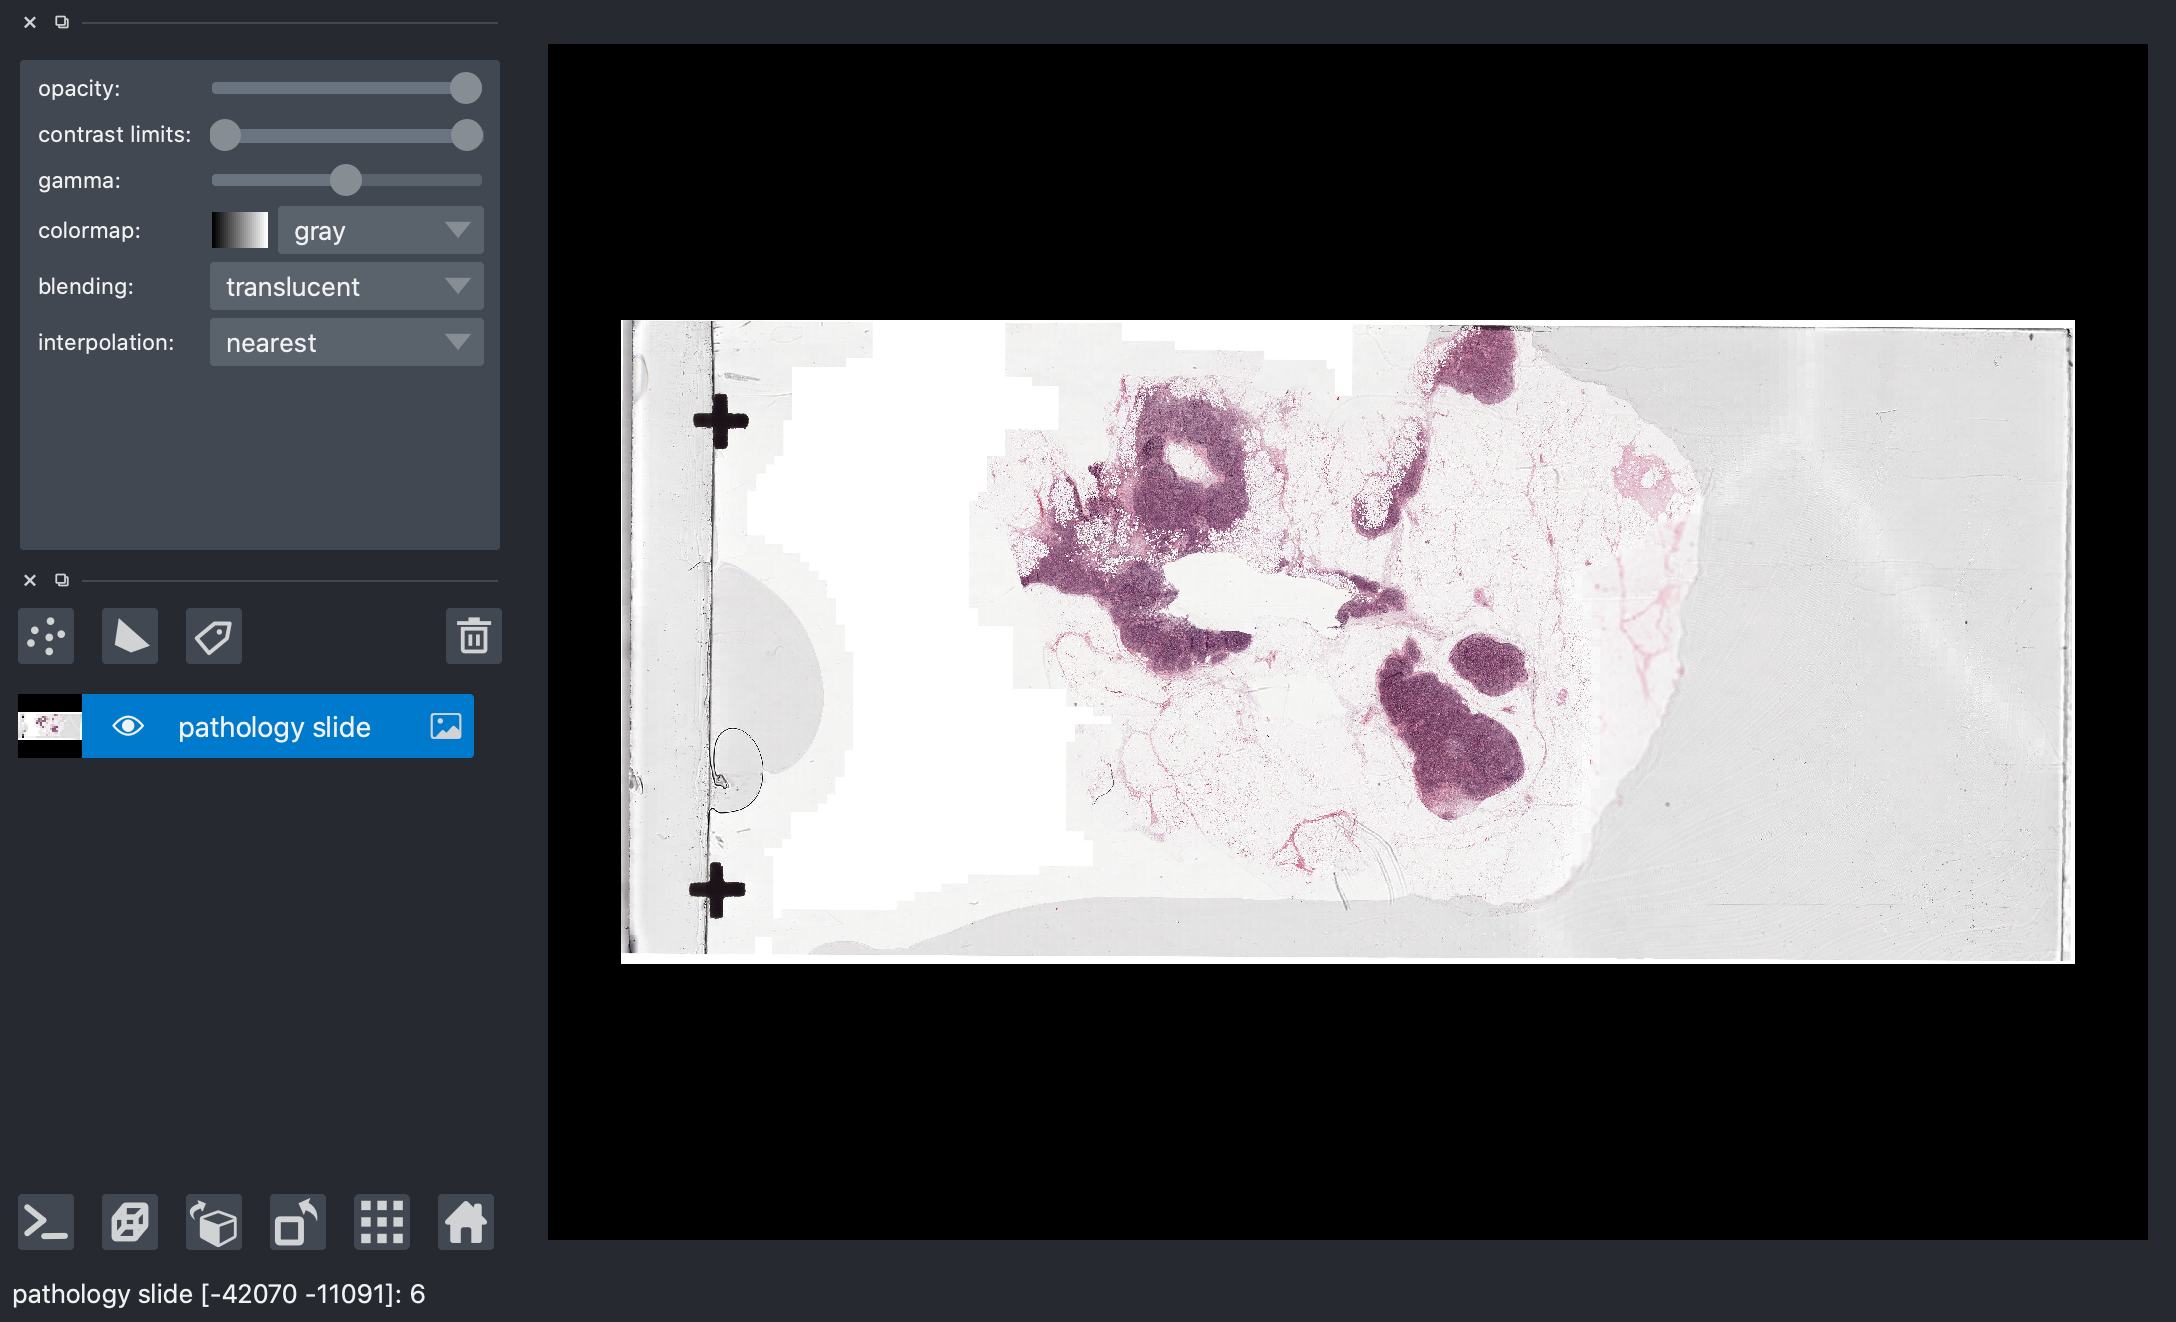

In [16]:
nbscreenshot(viewer)

### Add an analyzed layer

In [30]:
def theshold_on_red(data, thresh):
    return data[:, :, 0] < thresh

In [31]:
thresholded_pyramid = [data.map_blocks(lambda block: theshold_on_red(block, 100), drop_axis=2, 
                                       chunks=data.chunksize[:-1], dtype=int)[:data.shape[0], :data.shape[1]]
                       for data in pyramid]

In [32]:
viewer.add_labels(thresholded_pyramid, name='thresholded', multiscale=True);

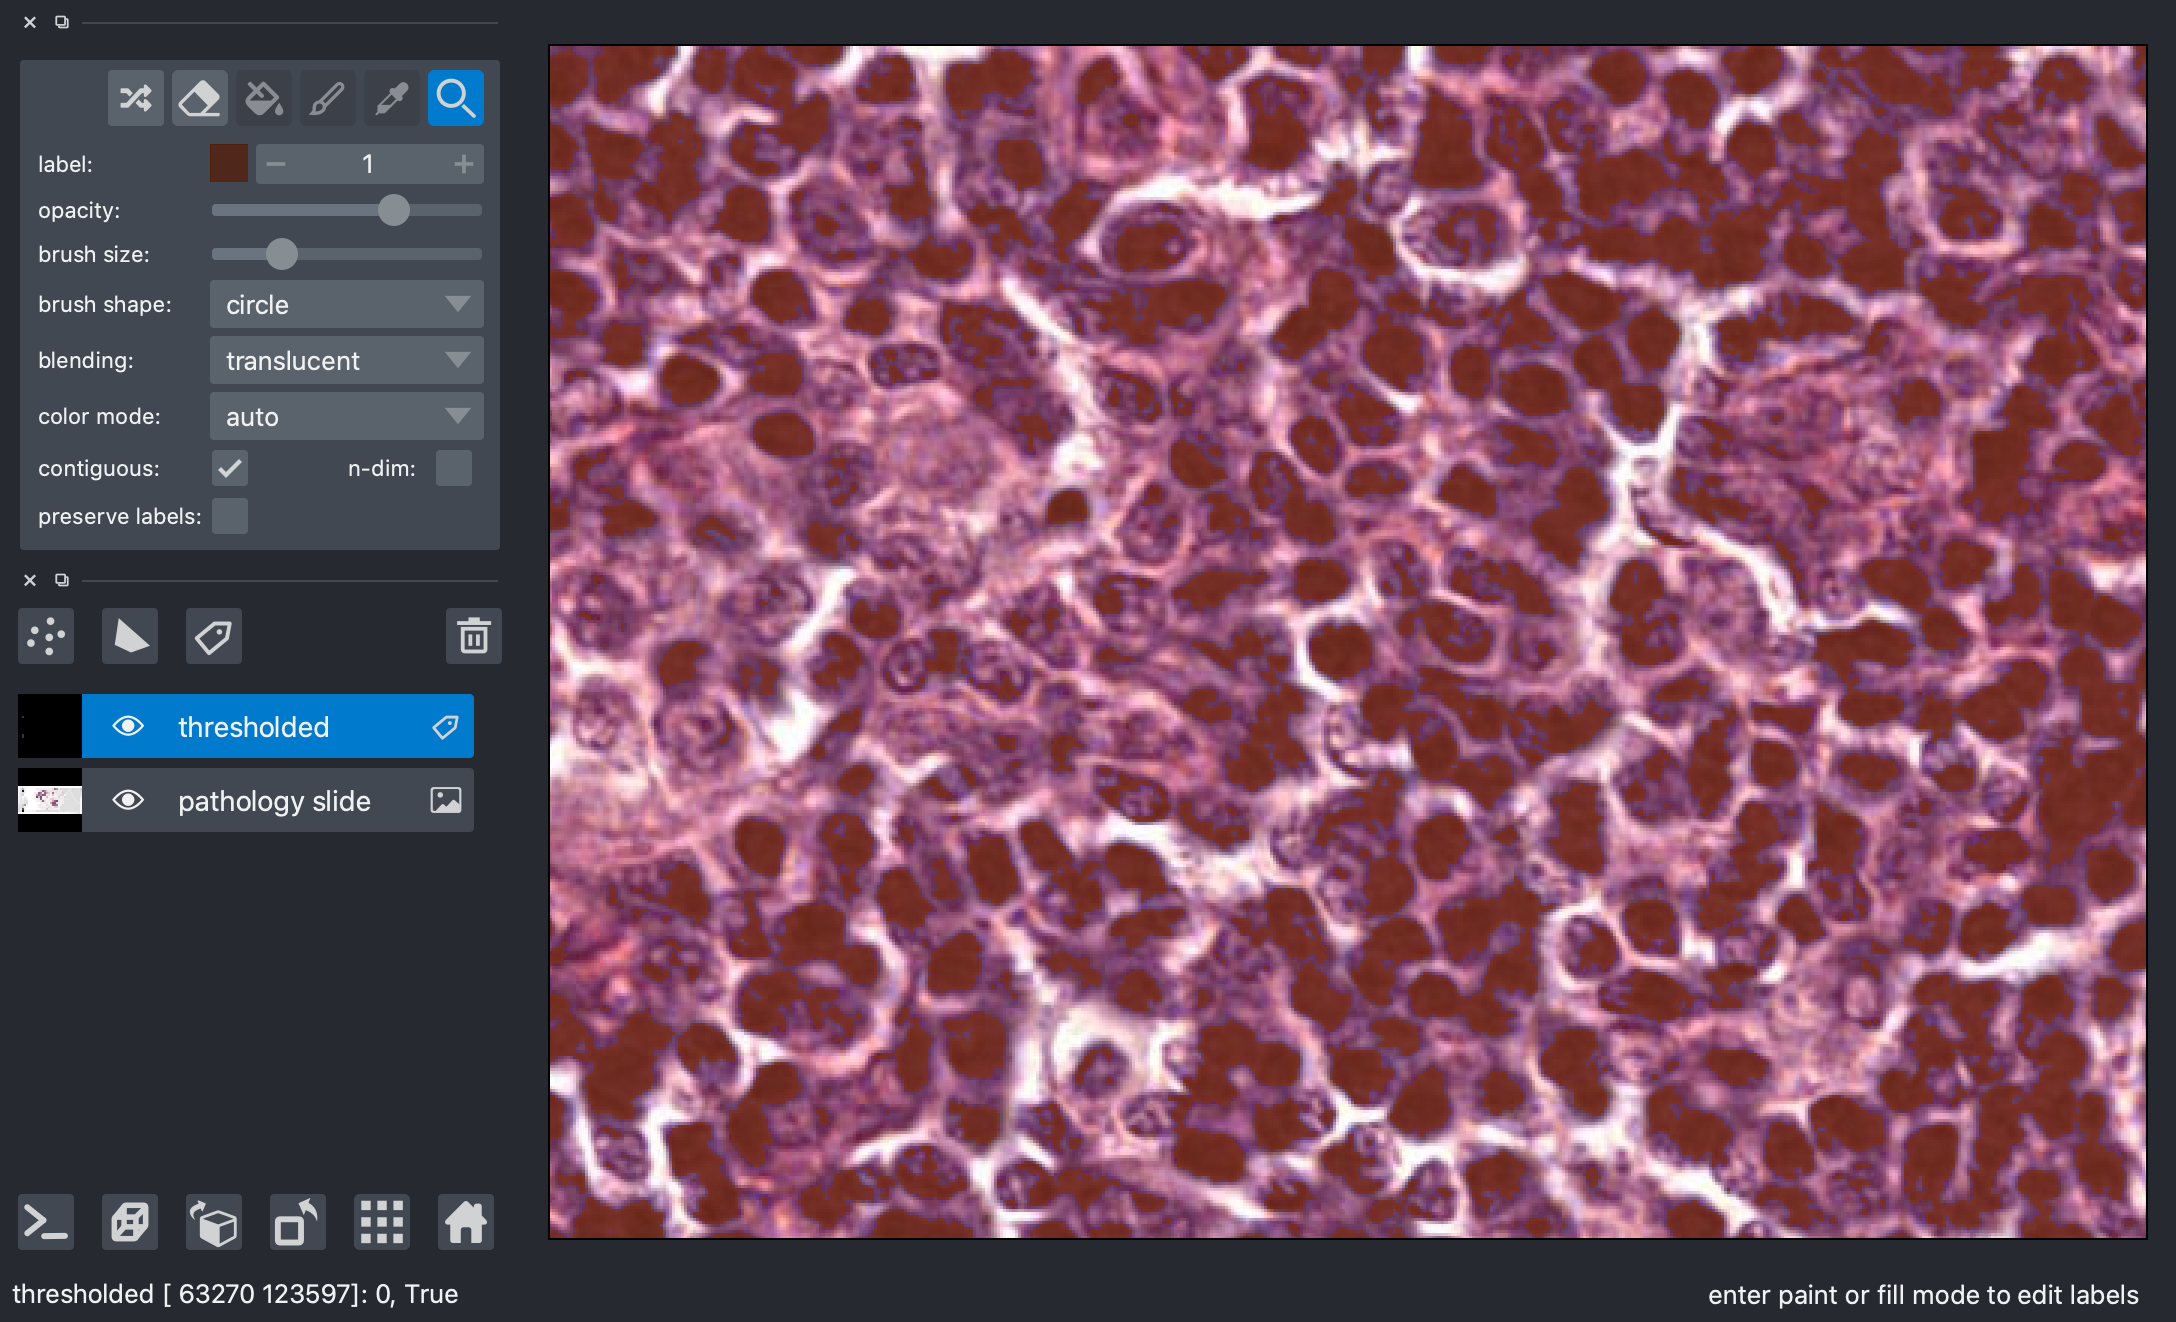

In [33]:
nbscreenshot(viewer)

## Interactive multiscale analysis

In [34]:
# Import magicgui and qt functionality
from qtpy.QtWidgets import QSlider
from qtpy.QtCore import Qt
from magicgui import magicgui


@magicgui(auto_call=True,
          value={'widget_type': QSlider, 'minimum': 0, 'maximum': 255, 'orientation':Qt.Horizontal})
def threshold(layer: napari.layers.Image, value: int = 100) -> napari.layers.Labels:
    return [data.map_blocks(lambda block: theshold_on_red(block, value), drop_axis=2, 
                                           chunks=data.chunksize[:-1], dtype=int)[:data.shape[0], :data.shape[1]]
                           for data in layer.data]

In [35]:
# create an empty viewer
viewer = napari.Viewer()

# add the pyramid
viewer.add_image(pyramid, name='pathology slide', multiscale=True);
viewer.window.add_dock_widget(threshold.Gui());

In [36]:
nbscreenshot(viewer)